## Redefine vertical level depths

Move vertical levels to avoid awkward jump in resolution near shelf break depth and weird bumps when calculating derivatives.

In [3]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns

In [6]:
# Datasets
Grid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/run01/gridGlob.nc' 
GridOut = Dataset(Grid)

# Vertical spacings
drC = GridOut.variables['drC'][:] # Zp1, r cell center separation (91)
drF = GridOut.variables['drF'][:] # Z, r cell face separation (90)

# R coordinates
RC = GridOut.variables['RC'][:] # (Z) R coordinate of cell center (90)
RF = GridOut.variables['RF'][:] # (Zp1) R coordinate of cell interface (91)
RL = GridOut.variables['RL'][:] # (Zl) R coordinate of lower interface (90)
RU = GridOut.variables['RU'][:] # (Z?) R coordinate of upper interface (90)

# Vertical Coordinates
Zp1 = GridOut.variables['Zp1'][:] # vertical coordinate of cell interface
Z = GridOut.variables['Z'][:] # vertical coordinate of cell center
Zl = GridOut.variables['Zl'][:] # vertical coordinate of upper cell interface

### Original vertical grids look like this:

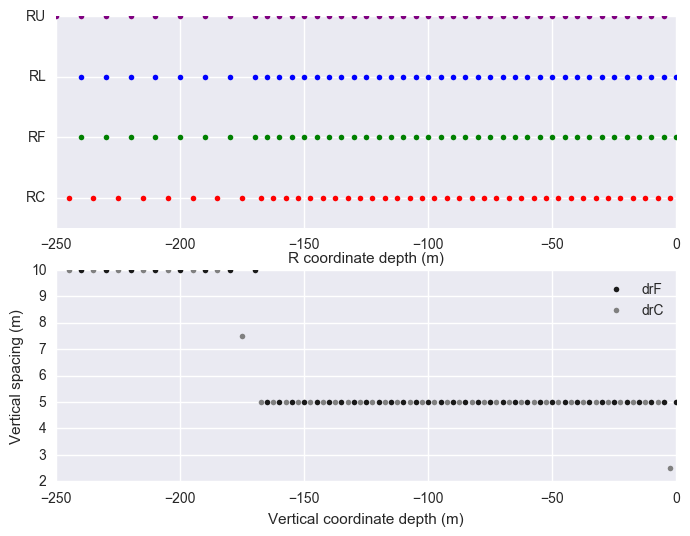

In [69]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(8,6))

ax1.plot(RC[:42],np.ones(len(RC[:42])),'ro',markersize=4)
ax1.plot(RF[:42],1.1*np.ones(len(RF[:42])),'go',markersize=4)
ax1.plot(RL[:42],1.2*np.ones(len(RL[:42])),'bo',markersize=4)
ax1.plot(RU[:42],1.3*np.ones(len(RU[:42])),'o',color='purple',markersize=4)
ax1.set_xlabel('R coordinate depth (m)',labelpad = 0)
ax1.set_yticks([1.0,1.1,1.2,1.3])
ax1.set_yticklabels(['RC','RF','RL','RU'])

ax2.plot(Zp1[:42],drF[:42],'o',color='0.1',markersize=4,label='drF')
ax2.plot(Z[:42],drC[:42],'o',color='0.5',markersize=4,label='drC')
ax2.set_xlabel('Vertical coordinate depth (m)')
ax2.set_ylabel('Vertical spacing (m)')
ax2.legend(loc=0)

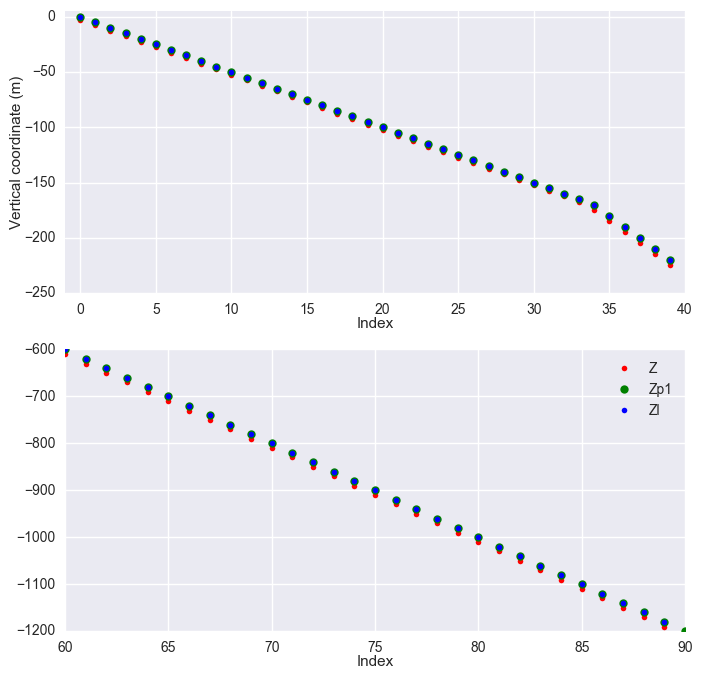

In [67]:
fig,(ax3,ax4) = plt.subplots(2,1, figsize=(8,8))

ax3.plot(Z[:40],'ro',markersize=4,label='Z')
ax3.plot(Zp1[:40],'go',markersize=6,label='Zp1')
ax3.plot(Zl[:40],'bo',markersize=4,label='Zl')
ax3.set_ylabel('Vertical coordinate (m)',labelpad = 0)
ax3.set_xlabel('Index',labelpad = 0)
ax3.set_xlim(-1,40)
ax3.set_ylim(-250,5)
ax4.plot(range(60,90),Z[60:],'ro',markersize=4,label='Z')
ax4.plot(range(60,91),Zp1[60:],'go',markersize=6,label='Zp1')
ax4.plot(range(60,90),Zl[60:],'bo',markersize=4,label='Zl')
ax4.set_xlabel('Index',labelpad = 0)
ax4.legend(loc=0)

|R coordinates|Description|Vertical coordinate|Size|Starts at (m)| Ends at (m)|
|:------------:|:---------:|:-----------------:|:------:|:---------:|:---------:|
|RC|of cell center|Z|90| -2.5 | -1190.0 |
|RF|of cell interface|Zp1|91| 0 | -1200.0 |
|RU|of lower interface|Zl|90| -5.0 | -1200.0 |
|RL|of upper interface|Z|90| 0 | -1180.0 |

|R spacing|Description|Vertical coordinate|Size|Starts with (m)| Ends with (m)|
|:------------:|:---------:|:-----------------:|:------:|:---------:|:---------:|
|drC|r cell center separation|Zp1|91| 2.5 | 10 |
|drF|r cell interface separation|Z|90| 5 | 20 |


I want smooth out the spacing and move the jumps where resolution decreases below 250 m. I will try a tanh function keeping 90 levels.

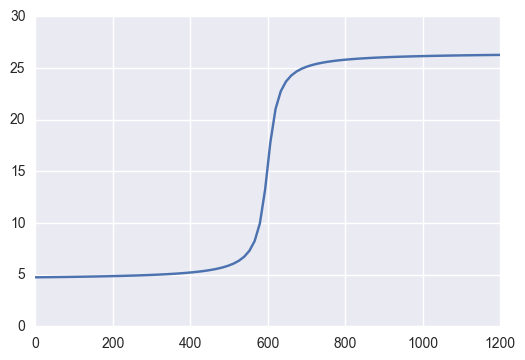

In [103]:
fig,ax1 = plt.subplots(1,1, figsize=(6,4))
ax1.plot(np.linspace(0,1200,90),7*np.arctan(0.05*np.linspace(-600,600,90))+15.5)